# e2e examples

In this notebook we will show how to compute a lognormal, apply and assess quality of reconstruction.
We use pypower; look at https://github.com/cosmodesi/pypower/blob/main/nb/pip_examples.ipynb to understand the pypower API.

In [1]:
import os
import tempfile

import numpy as np
from matplotlib import pyplot as plt

# For mockfactory installation, see https://github.com/adematti/mockfactory
from mockfactory import EulerianLinearMock, LagrangianLinearMock, utils, setup_logging
# For cosmoprimo installation, see https://cosmoprimo.readthedocs.io/en/latest/user/building.html
from cosmoprimo.fiducial import DESI

from pyrecon import MultiGridReconstruction, IterativeFFTReconstruction, PlaneParallelFFTReconstruction
# For pypower installation, see https://pypower.readthedocs.io/en/latest/user/building.html
from pypower import CatalogFFTPower
from pyrecon.metrics import MeshFFTCorrelator, MeshFFTPropagator, CatalogMesh

# Set up logging
setup_logging()
z = 1.
# Load DESI fiducial cosmology
cosmo = DESI()
power = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
f = cosmo.sigma8_z(z=z,of='theta_cb')/cosmo.sigma8_z(z=z,of='delta_cb') # growth rate

## Lognormal mock in box

In [2]:
bias, nbar, nmesh, boxsize, boxcenter, los = 2.0, 1e-3, 200, 1000., 0., 'x'

mock = LagrangianLinearMock(power, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=42, unitary_amplitude=False)
# This is Lagrangian bias, Eulerian bias - 1
mock.set_real_delta_field(bias=bias-1)
mesh_real = mock.mesh_delta_r + 1.
mock.set_analytic_selection_function(nbar=nbar)
mock.poisson_sample(seed=43)
mock.set_rsd(f=f, los=los)
data = mock.to_catalog()
offset = data.boxcenter - data.boxsize/2.
data['Position'] = (data['Position'] - offset) % data.boxsize + offset

from mockfactory.make_survey import RandomBoxCatalog
randoms = RandomBoxCatalog(nbar=nbar, boxsize=boxsize, boxcenter=boxcenter, seed=44)

[000003.26] [0/1] 02-25 18:16  LagrangianLinearMock      INFO     White noise generated.
[000005.77] [0/1] 02-25 18:16  LagrangianLinearMock      INFO     Poisson sampling done, total number of objects is 1000661.
[000007.15] [0/1] 02-25 18:16  LagrangianLinearMock      INFO     Catalog produced. Assigning in cell shift.


## Run reconstruction

In [3]:
#ReconstructionAlgorithm = MultiGridReconstruction # choose your algorithm
ReconstructionAlgorithm = IterativeFFTReconstruction
#ReconstructionAlgorithm = PlaneParallelFFTReconstruction
recon = ReconstructionAlgorithm(f=f, bias=bias, los=los, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, fft_engine='fftw', fft_plan='estimate')
recon.assign_data(data.gget('Position'))
recon.set_density_contrast()
# Run reconstruction
recon.run()

data['Position_rec'] = data['Position'] - recon.read_shifts(data['Position'], field='disp+rsd')
randoms['Position_rec'] = randoms['Position'] - recon.read_shifts(randoms['Position'], field='disp')
offset = data.boxcenter - data.boxsize/2.
for catalog in [data, randoms]:
    catalog['Position_rec'] = (catalog['Position_rec'] - offset) % catalog.boxsize + offset

[000010.14] [0/1] 02-25 18:16  IterativeFFTReconstruction INFO     Using mesh RealMesh(dtype=float64, nmesh=[200 200 200], boxsize=[1000. 1000. 1000.], boxcenter=[0. 0. 0.]).
[000010.16] [0/1] 02-25 18:16  IterativeFFTReconstruction INFO     Using 4 nthreads.
[000011.07] [0/1] 02-25 18:16  IterativeFFTReconstruction INFO     Running iteration 0.
[000011.67] [0/1] 02-25 18:17  IterativeFFTReconstruction INFO     Running iteration 1.
[000012.34] [0/1] 02-25 18:17  IterativeFFTReconstruction INFO     Running iteration 2.


## Estimate power spectrum multipoles

[000015.51] [0/1] 02-25 18:17  CatalogFFTPower           INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[200 200 200], boxsize=[1000. 1000. 1000.], boxcenter=[0. 0. 0.], dtype=float64).
[000016.48] [0/1] 02-25 18:17  CatalogMesh               INFO     Running interlacing at order 2.
[000018.06] [0/1] 02-25 18:17  CatalogFFTPower           INFO     Done painting catalog 1 to mesh.
[000018.06] [0/1] 02-25 18:17  CatalogFFTPower           INFO     Using 77 k-bins between 0.010 and 0.395.
[000018.06] [0/1] 02-25 18:17  CatalogFFTPower           INFO     Running power spectrum estimation.
[000020.42] [0/1] 02-25 18:17  CatalogFFTPower           INFO     Power spectrum computed in elapsed time 2.36 s.
[000020.58] [0/1] 02-25 18:17  CatalogFFTPower           INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[200 200 200], boxsize=[1000. 1000. 1000.], boxcenter=[0. 0. 0.], dtype=float64).
[000022.14] [0/1] 02-25 18:17  CatalogMesh               INFO     Running interlacing at order 

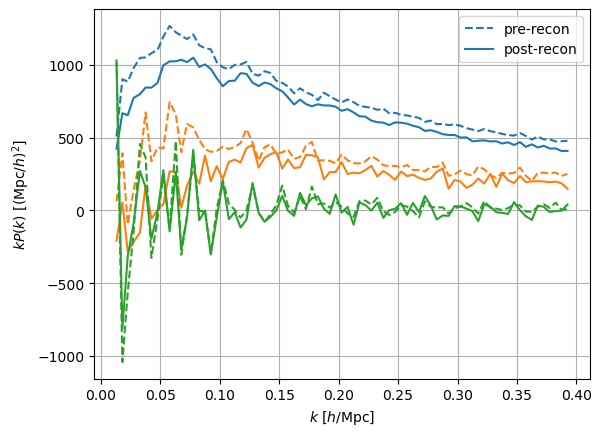

In [4]:
kedges = np.arange(0.01, 0.4, 0.005)

poles = CatalogFFTPower(data_positions1=data['Position'], boxsize=boxsize, boxcenter=boxcenter, nmesh=nmesh, resampler='cic',
                        interlacing=2, ells=(0, 2, 4), los=los, edges=kedges, position_type='pos').poles

poles_recon = CatalogFFTPower(data_positions1=data['Position_rec'], shifted_positions1=randoms['Position_rec'],
                              boxsize=boxsize, boxcenter=boxcenter, nmesh=nmesh, resampler='cic', interlacing=2, ells=(0, 2, 4), los=los, edges=kedges, position_type='pos').poles

ax = plt.gca()
for ill, ell in enumerate(poles.ells):
    ax.plot(poles.k, poles.k*poles(ell=ell, complex=False), color='C{:d}'.format(ill), linestyle='--', label='pre-recon' if ill == 0 else None)
    ax.plot(poles_recon.k, poles_recon.k*poles_recon(ell=ell, complex=False), color='C{:d}'.format(ill), linestyle='-', label='post-recon' if ill == 0 else None)
ax.legend()
ax.grid(True)
ax.set_xlabel('$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

## Compute correlator to assess reconstruction

In [5]:
mesh_recon = CatalogMesh(data['Position_rec'], shifted_positions=randoms['Position_rec'],
                         boxsize=boxsize, boxcenter=boxcenter, nmesh=nmesh, resampler='tsc',
                         interlacing=3, position_type='pos')

muedges = np.linspace(-1., 1., 5)
correlator = MeshFFTCorrelator(mesh_recon, mesh_real, edges=(kedges, muedges), los=los)

[000027.96] [0/1] 02-25 18:17  MeshFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[200 200 200], boxsize=[1000. 1000. 1000.], boxcenter=[0. 0. 0.], dtype=float64).
[000029.45] [0/1] 02-25 18:17  CatalogMesh               INFO     Running interlacing at order 3.
[000033.49] [0/1] 02-25 18:17  MeshFFTPower              INFO     Done painting catalog 1 to mesh.
[000033.49] [0/1] 02-25 18:17  MeshFFTPower              INFO     Using 77 k-bins between 0.010 and 0.395.
[000033.50] [0/1] 02-25 18:17  MeshFFTPower              INFO     Running power spectrum estimation.
[000034.71] [0/1] 02-25 18:17  MeshFFTPower              INFO     Power spectrum computed in elapsed time 1.21 s.
[000034.71] [0/1] 02-25 18:17  MeshFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[200 200 200], boxsize=[1000. 1000. 1000.], boxcenter=[0. 0. 0.], dtype=float64).
[000036.55] [0/1] 02-25 18:17  CatalogMesh               INFO     Running interlacing at order 

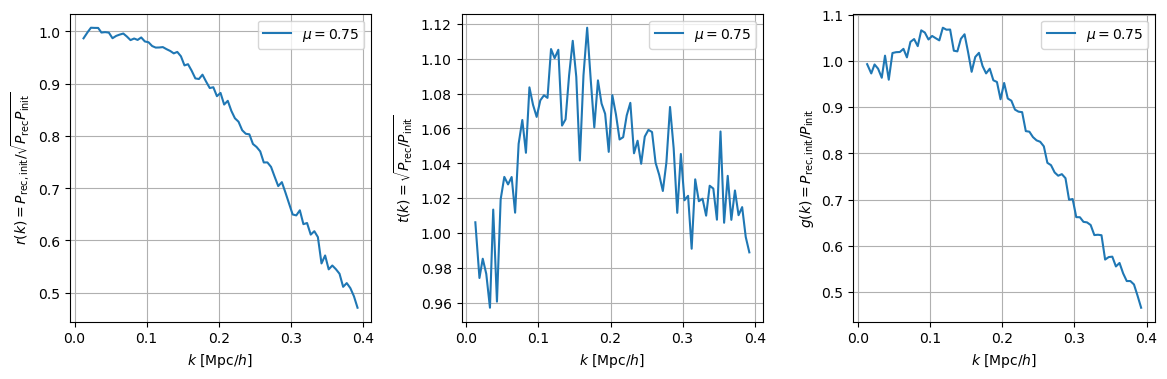

In [6]:
propagator = correlator.to_propagator(growth=bias)
transfer = correlator.to_transfer(growth=bias)
fig, lax = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
fig.subplots_adjust(wspace=0.3)
lax = lax.flatten()
for imu, mu in enumerate(correlator.muavg[3:]):
    k = correlator.k[:,imu]
    lax[0].plot(k, correlator(k=k, mu=mu), label=r'$\mu = {:.2f}$'.format(mu))
    lax[1].plot(k, transfer(k=k, mu=mu), label=r'$\mu = {:.2f}$'.format(mu))
    lax[2].plot(k, propagator(k=k, mu=mu), label=r'$\mu = {:.2f}$'.format(mu))
for ax in lax:
    ax.legend()
    ax.grid(True)
    ax.set_xlabel('$k$ [$\mathrm{Mpc}/h$]')
lax[0].set_ylabel(r'$r(k) = P_{\mathrm{rec},\mathrm{init}}/\sqrt{P_{\mathrm{rec}}P_{\mathrm{init}}}$')
lax[1].set_ylabel(r'$t(k) = \sqrt{P_{\mathrm{rec}}/P_{\mathrm{init}}}$')
lax[2].set_ylabel(r'$g(k) = P_{\mathrm{rec},\mathrm{init}}/P_{\mathrm{init}}$')
plt.show()

In [7]:
# You can save the result (similarly for MeshFFTCorrelator and MeshFFTTransfer)
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    propagator.save(fn)
    # And reload the result
    propagator = MeshFFTPropagator.load(fn)
    print(propagator.edges[0])

[000043.62] [0/1] 02-25 18:17  MeshFFTPropagator         INFO     Saving /tmp/tmpda0e1hix/tmp.npy.
[000043.63] [0/1] 02-25 18:17  MeshFFTPropagator         INFO     Loading /tmp/tmpda0e1hix/tmp.npy.
[0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06  0.065
 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115 0.12  0.125
 0.13  0.135 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175 0.18  0.185
 0.19  0.195 0.2   0.205 0.21  0.215 0.22  0.225 0.23  0.235 0.24  0.245
 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285 0.29  0.295 0.3   0.305
 0.31  0.315 0.32  0.325 0.33  0.335 0.34  0.345 0.35  0.355 0.36  0.365
 0.37  0.375 0.38  0.385 0.39  0.395]


## MPI
**pypower** is MPI-parallelized (not pyrecon, though). Let's start from initial conditions and catalogs saved on disk.

In [8]:
# Save above initial conditions and (reconstructed) catalogs
base_dir = '_tests'
utils.mkdir(base_dir)

init_fn = os.path.join(base_dir, 'initial_conditions.npy')
np.save(init_fn, mesh_real.value)

data_fn = os.path.join(base_dir, 'data.fits')
randoms_fn = os.path.join(base_dir, 'randoms.fits')
data.save_fits(data_fn)
randoms.save_fits(randoms_fn)

[000043.88] [0/1] 02-25 18:17  FitsFile                  INFO     Saving to _tests/data.fits.
[000044.40] [0/1] 02-25 18:17  FitsFile                  INFO     Saving to _tests/randoms.fits.


In [9]:
%%file '_tests/script.py'

import os

import numpy as np

from pyrecon.metrics import MeshFFTCorrelator, MeshFFTPropagator, ArrayMesh, CatalogMesh
from pypower import mpi, setup_logging

# To activate logging
setup_logging()

base_dir = '_tests'
init_fn = os.path.join(base_dir, 'initial_conditions.npy')
data_fn = os.path.join(base_dir, 'data.fits')
randoms_fn = os.path.join(base_dir, 'randoms.fits')

mpicomm = mpi.COMM_WORLD
kedges = np.arange(0.01, 0.4, 0.005)
muedges = np.linspace(-1., 1., 5)
boxsize, boxcenter, los = 1000., 0., 'x'

# Load mesh
mpiroot = 0
if mpicomm.rank == mpiroot:
    mesh_init = np.load(init_fn)
else:
    mesh_init = None
mesh_init = ArrayMesh(mesh_init, boxsize, mpiroot=mpiroot, mpicomm=mpicomm)

# Read input catalogs, scattering on all MPI ranks (1 in this notebook)
def read(fn, column='Position_rec', ext=1):
    #import fitsio
    #gsize = fitsio.FITS(fn)[ext].get_nrows()
    #start, stop = mpicomm.rank * gsize // mpicomm.size, (mpicomm.rank + 1) * gsize // mpicomm.size
    #tmp = fitsio.read(fn, ext=ext, columns=[column], rows=range(start, stop))
    #return tmp[column]
    from mockfactory import Catalog
    catalog = Catalog.load_fits(fn, ext=ext, mpicomm=mpicomm)
    return catalog[column]
    
data_positions_rec = read(data_fn)
randoms_positions_rec = read(randoms_fn)
mesh_recon = CatalogMesh(data_positions_rec, shifted_positions=randoms_positions_rec,
                         boxsize=boxsize, boxcenter=boxcenter, nmesh=mesh_init.pm.Nmesh, resampler='tsc',
                         interlacing=3, position_type='pos', mpicomm=mpicomm, mpiroot=None)

muedges = np.linspace(-1., 1., 5)
correlator = MeshFFTCorrelator(mesh_recon, mesh_init, edges=(kedges, muedges), los=los)

fn = os.path.join(base_dir, 'correlator.npy')
correlator.save(fn)

Overwriting _tests/script.py


In [10]:
%%bash
mpiexec -np 4 python _tests/script.py

[000007.21]  02-25 18:17  FitsFile                     INFO     Loading _tests/data.fits.
[000007.29]  02-25 18:17  FitsFile                     INFO     Loading _tests/randoms.fits.
[000007.45]  02-25 18:17  MeshFFTPower                 INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[200 200 200], boxsize=[1000. 1000. 1000.], boxcenter=[0. 0. 0.], dtype=float64).
[000008.17]  02-25 18:17  CatalogMesh                  INFO     Running interlacing at order 3.
[000010.45]  02-25 18:17  MeshFFTPower                 INFO     Done painting catalog 1 to mesh.
[000010.45]  02-25 18:17  MeshFFTPower                 INFO     Using 77 k-bins between 0.010 and 0.395.
[000010.45]  02-25 18:17  MeshFFTPower                 INFO     Running power spectrum estimation.
[000011.10]  02-25 18:17  MeshFFTPower                 INFO     Power spectrum computed in elapsed time 0.64 s.
[000011.10]  02-25 18:17  MeshFFTPower                 INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[200 200

/local/home/adematti/anaconda3/envs/cosmopipe-dev/lib/python3.8/site-packages/pmesh/domain.py:380: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.edges = numpy.asarray(edges)
/local/home/adematti/anaconda3/envs/cosmopipe-dev/lib/python3.8/site-packages/pmesh/domain.py:380: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.edges = numpy.asarray(edges)
/local/home/adematti/anaconda3/envs/cosmopipe-dev/lib/python3.8/site-packages/pmesh/domain.py:380: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

In [11]:
!ls -l _tests

total 148564
-rw-r----- 1 adematti idphp    56286 févr. 25 18:17 correlator.npy
-rw-r----- 1 adematti idphp 72054720 févr. 25 18:17 data.fits
-rw-r----- 1 adematti idphp 32000128 févr. 25 18:17 initial_conditions.npy
-rw-r----- 1 adematti idphp 48006720 févr. 25 18:17 randoms.fits
-rw-r----- 1 adematti idphp     1769 févr. 25 18:17 script.py


[000061.39] [0/1] 02-25 18:17  MeshFFTCorrelator         INFO     Loading _tests/correlator.npy.


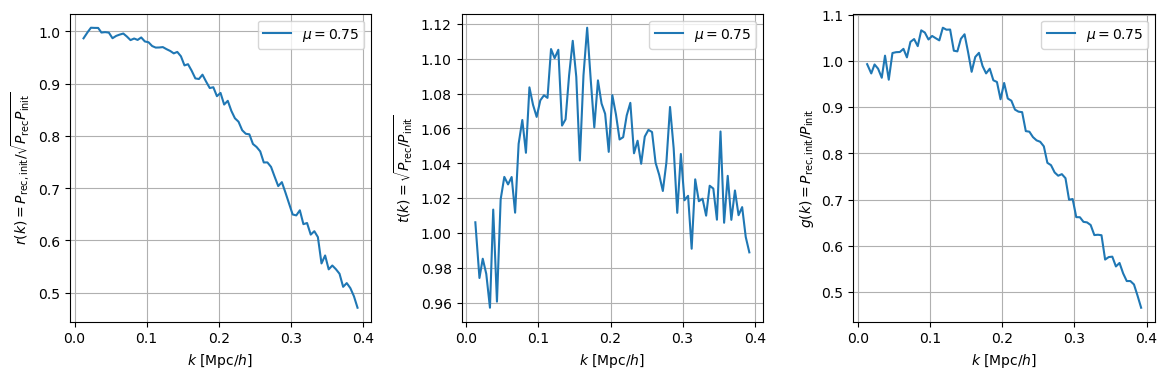

In [12]:
fn = os.path.join(base_dir, 'correlator.npy')
correlator_mpi = MeshFFTCorrelator.load(fn)

# We have the same correlator as in the non-MPI case!
assert np.allclose(correlator_mpi.ratio, correlator.ratio)

correlator = correlator_mpi
propagator = correlator.to_propagator(growth=bias)
transfer = correlator.to_transfer(growth=bias)
fig, lax = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
fig.subplots_adjust(wspace=0.3)
lax = lax.flatten()
for imu, mu in enumerate(correlator.muavg[3:]):
    k = correlator.k[:,imu]
    lax[0].plot(k, correlator(k=k, mu=mu), label=r'$\mu = {:.2f}$'.format(mu))
    lax[1].plot(k, transfer(k=k, mu=mu), label=r'$\mu = {:.2f}$'.format(mu))
    lax[2].plot(k, propagator(k=k, mu=mu), label=r'$\mu = {:.2f}$'.format(mu))
for ax in lax:
    ax.legend()
    ax.grid(True)
    ax.set_xlabel('$k$ [$\mathrm{Mpc}/h$]')
lax[0].set_ylabel(r'$r(k) = P_{\mathrm{rec},\mathrm{init}}/\sqrt{P_{\mathrm{rec}}P_{\mathrm{init}}}$')
lax[1].set_ylabel(r'$t(k) = \sqrt{P_{\mathrm{rec}}/P_{\mathrm{init}}}$')
lax[2].set_ylabel(r'$g(k) = P_{\mathrm{rec},\mathrm{init}}/P_{\mathrm{init}}$')
plt.show()